Загружаем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

## Загружаем датасет

In [3]:
df = pd.read_excel('Canada Crude Oil Production.xlsx')
df.head()

,Month,Canada Total
0,2000-01-01,2.146907e+06
1,2000-02-01,2.160835e+06
2,2000-03-01,2.080255e+06
3,2000-04-01,2.139488e+06
4,2000-05-01,2.185353e+06


In [4]:
import seaborn as sns

In [5]:
df['Month'].value_counts()

Month
2000-01-01    1
2012-10-01    1
2012-12-01    1
2013-01-01    1
2013-02-01    1
             ..
2007-02-01    1
2007-03-01    1
2007-04-01    1
2007-05-01    1
2020-04-01    1
Name: count, Length: 244, dtype: int64

Количество дат = 244

In [6]:
df.duplicated().sum()

0

## Статический анализ

### Тренд

Попробуем построить график зависимости производства от месяцев, чтобы оценить тренд.

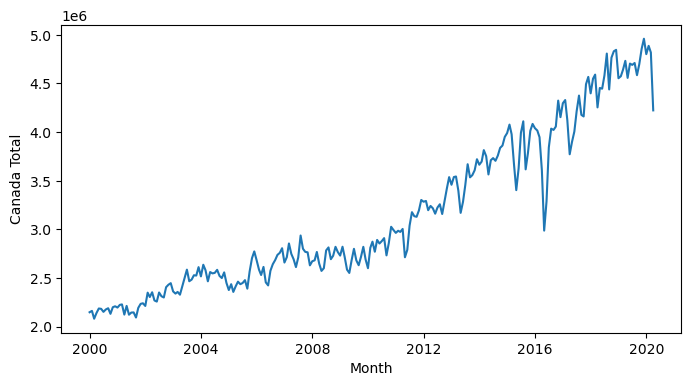

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(x=df['Month'], y=df['Canada Total'], ax=ax)
plt.show()

Из данного графика очевидно, что в длительной перспективе производство увеличивается. Значит тренд восходящий.

### Сезонность

Теперь попробуем проанализировать сезонность, для этого построим график, выделив ежемесячное производство в год

In [8]:
df['Month Index'] = df['Month'].dt.month
df['Year'] = df['Month'].dt.year

In [9]:
df_pivot = pd.pivot_table(df, values='Canada Total', columns='Year', index='Month Index')

In [10]:
df_pivot.head(5)

Year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Month Index,,,,,,,,,,,,,,,,,,,,,
1,2.146907e+06,2.195003e+06,2.211578e+06,2.361016e+06,2.515354e+06,2.375141e+06,2.681053e+06,2.657726e+06,2.671065e+06,2.729175e+06,...,2.962550e+06,3.283005e+06,3.457240e+06,3.663140e+06,3.988549e+06,4.038561e+06,4.294920e+06,4.397033e+06,4.552131e+06,4.799592e+06
2,2.160835e+06,2.222614e+06,2.348132e+06,2.338369e+06,2.634962e+06,2.435214e+06,2.584846e+06,2.713150e+06,2.680422e+06,2.820233e+06,...,2.984462e+06,3.290701e+06,3.536511e+06,3.695729e+06,4.075569e+06,4.014636e+06,4.328010e+06,4.547520e+06,4.572446e+06,4.884952e+06
3,2.080255e+06,2.227287e+06,2.303421e+06,2.355720e+06,2.579434e+06,2.355805e+06,2.529613e+06,2.854015e+06,2.766524e+06,2.716178e+06,...,2.972440e+06,3.195827e+06,3.542302e+06,3.813193e+06,3.976010e+06,3.946195e+06,4.119671e+06,4.589397e+06,4.638241e+06,4.816667e+06
4,2.139488e+06,2.122541e+06,2.352190e+06,2.327243e+06,2.464830e+06,2.413170e+06,2.612783e+06,2.746770e+06,2.645962e+06,2.584828e+06,...,3.003135e+06,3.239590e+06,3.395792e+06,3.750964e+06,3.668169e+06,3.604744e+06,3.770627e+06,4.252441e+06,4.731008e+06,4.221791e+06
5,2.185353e+06,2.212061e+06,2.267952e+06,2.412907e+06,2.560092e+06,2.461109e+06,2.454160e+06,2.692105e+06,2.571673e+06,2.550798e+06,...,2.711819e+06,3.215839e+06,3.168557e+06,3.563234e+06,3.402003e+06,2.985887e+06,3.896619e+06,4.452188e+06,4.555873e+06,NaN


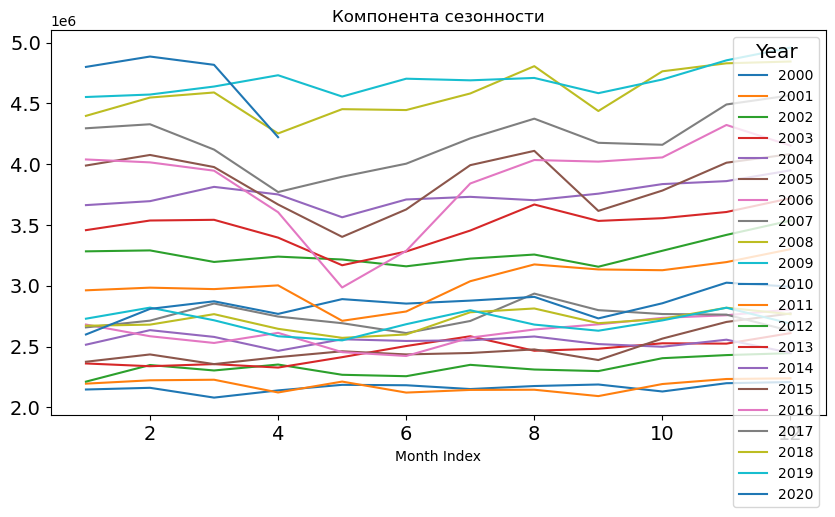

In [11]:
plt.rcParams['legend.title_fontsize'] = 'x-large'

df_pivot.plot( figsize=(10, 5),title= 'Компонента сезонности', fontsize=14)
plt.show()

Из данного графика не очень понятно есть ли сезонность, есть некоторые паттерны, например в 2015, 2016 (коричневая и розовая линии) (Возможно картинка не сохранилась, поскольку она у меня в директории...)

![Сезонноость](Сезонность.PNG)

### Шум

Исходя из графиков выше(для тренда и сезонности) можно сказать, что временной ряд имеет шум, поскольку данные "скачут", в некоторых местах даже очень сильно (например, 2016 год)

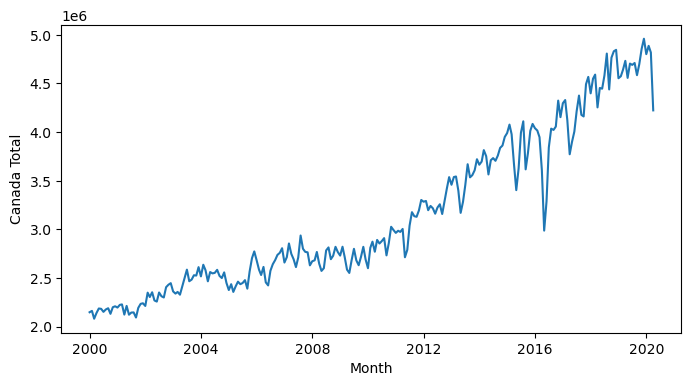

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(x=df['Month'], y=df['Canada Total'], ax=ax)
plt.show()

## Декомпозиция и обратная композиция

### Декомпозиция

Используем библиотеку чтобы сделать декомпозицию

In [13]:
import statsmodels.api as sm

In [14]:
df_comp = df.copy()
df_comp['Month'] = pd.to_datetime(df_comp['Month'])

In [15]:
df_comp.drop(columns=['Month Index', 'Year'], inplace=True)
df_comp.set_index('Month', inplace=True)

In [16]:
df_comp.head(5)

,Canada Total
Month,
2000-01-01,2.146907e+06
2000-02-01,2.160835e+06
2000-03-01,2.080255e+06
2000-04-01,2.139488e+06
2000-05-01,2.185353e+06


In [17]:
decomposition = sm.tsa.seasonal_decompose(df_comp)

In [18]:
decomposed_data = pd.DataFrame()

decomposed_data['trend'] = decomposition.trend

decomposed_data['seasonal'] = decomposition.seasonal

decomposed_data['random_noise'] = decomposition.resid

In [19]:
decomposed_data.tail(10)

,trend,seasonal,random_noise
Month,,,
2019-07-01,4.697160e+06,6518.679160,-14440.230099
2019-08-01,4.720492e+06,57289.632453,-68928.194153
2019-09-01,4.740948e+06,-56563.779476,-100736.507968
2019-10-01,4.727165e+06,6596.641178,-37625.174308
2019-11-01,NaN,96275.835655,NaN
2019-12-01,NaN,95635.219596,NaN
2020-01-01,NaN,25536.704022,NaN
2020-02-01,NaN,67025.930791,NaN
2020-03-01,NaN,41485.327159,NaN


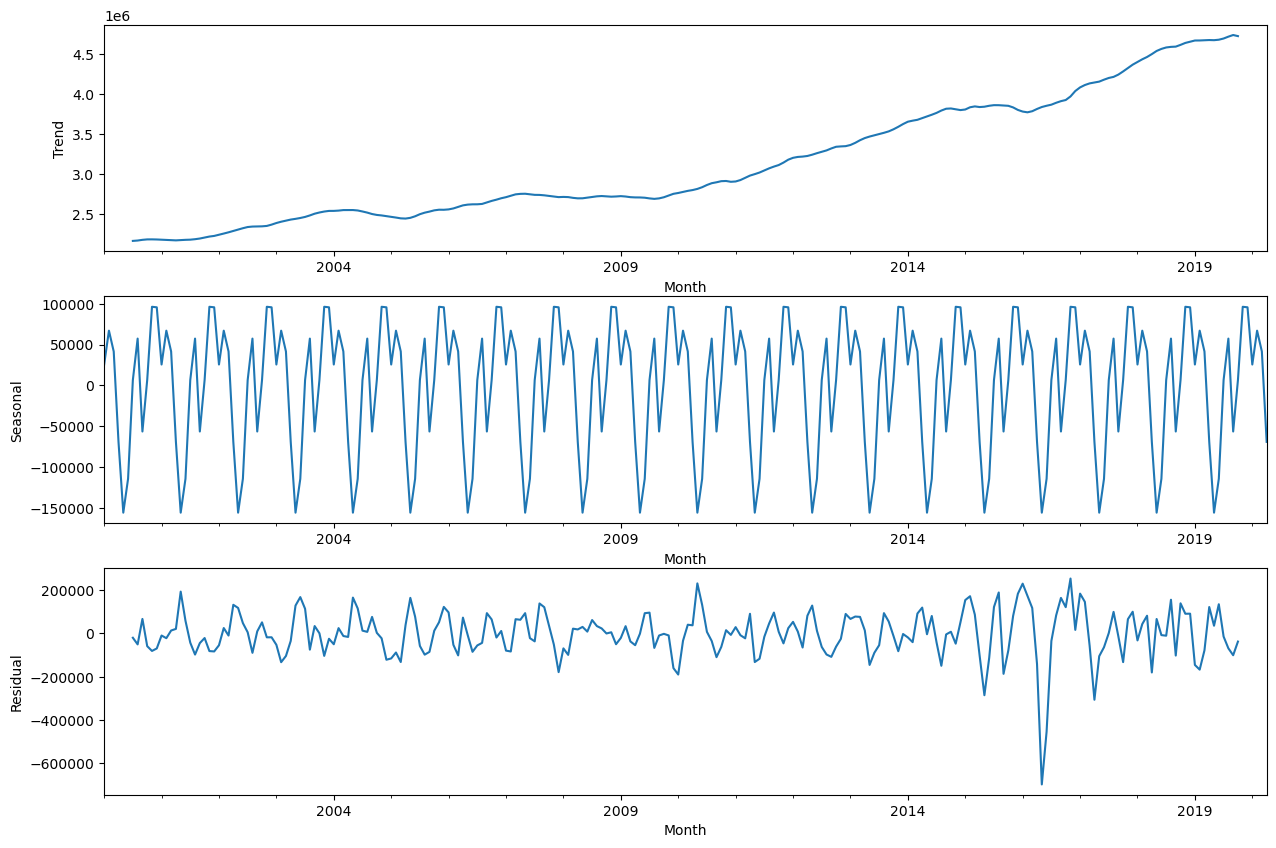

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 10))

decomposed_data['trend'].plot(ax = ax1)
ax1.set_ylabel('Trend')

decomposed_data['seasonal'].plot(ax = ax2)
ax2.set_ylabel('Seasonal')

decomposed_data['random_noise'].plot(ax = ax3)
ax3.set_ylabel('Residual')

plt.show()

Из графиков можем заметить:
* тренд действительно возрастает, значит восходящий
* сезоность присутствует, чего нельзя было сказать по прошлому графику

### Композиция

Попробуем восстановить ряд из нашей декомпозиции.

Text(0.5, 1.0, 'Исходный ряд')

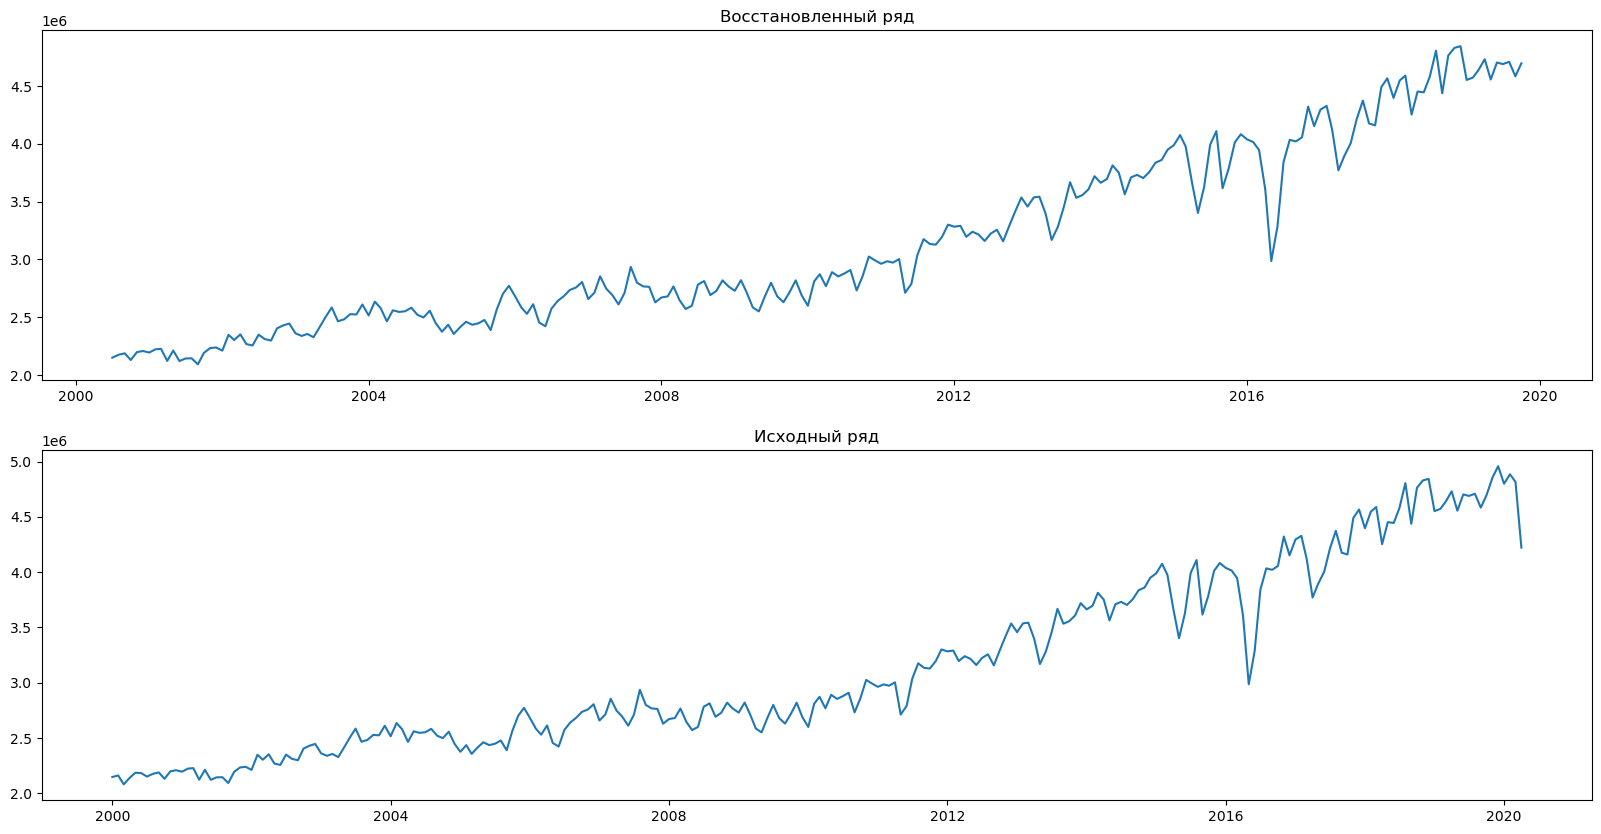

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))

ax[0].plot(decomposed_data['trend'] + decomposed_data['seasonal'] + decomposed_data['random_noise'])
ax[0].set_title('Восстановленный ряд')
ax[1].plot(df_comp)
ax[1].set_title('Исходный ряд')

Как можно заметить графики идентичны, за исключением начала и конца, поскольку
```
statsmodels.api.tsa.seasonal_decompose
```
зануляет начало и конец для получения более надежных результатов.

## Построение модели

In [22]:
df['Canada Total'].describe()

count    2.440000e+02
mean     3.151212e+06
std      8.033855e+05
min      2.080255e+06
25%      2.526269e+06
50%      2.819307e+06
75%      3.760561e+06
max      4.958290e+06
Name: Canada Total, dtype: float64

Нормализуем наши данные чтобы не было проблем с оптимизацией в процессе обучения

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df[['Canada Total']].values)

In [25]:
dataset[0:10]

array([[0.02315867],
       [0.02799817],
       [0.        ],
       [0.02058091],
       [0.03651723],
       [0.03533255],
       [0.02449761],
       [0.03308465],
       [0.03745898],
       [0.01750509]])

In [26]:
def train_test_split(df):
    train_size = int(df.shape[0] * 0.7)
    return df[:train_size], df[train_size:]

In [27]:
train, test = train_test_split(dataset)

In [31]:
train

array([[0.02315867],
       [0.02799817],
       [0.        ],
       [0.02058091],
       [0.03651723],
       [0.03533255],
       [0.02449761],
       [0.03308465],
       [0.03745898],
       [0.01750509],
       [0.04115057],
       [0.04444838],
       [0.03987036],
       [0.04946402],
       [0.05108773],
       [0.01469262],
       [0.0457972 ],
       [0.0143697 ],
       [0.0219823 ],
       [0.02253433],
       [0.00432622],
       [0.03881388],
       [0.05316348],
       [0.05512335],
       [0.04562927],
       [0.09307635],
       [0.07754102],
       [0.09448617],
       [0.06521708],
       [0.0611646 ],
       [0.09363545],
       [0.08026916],
       [0.07578632],
       [0.11261647],
       [0.12147032],
       [0.12697914],
       [0.09755309],
       [0.08968392],
       [0.09571279],
       [0.08581816],
       [0.11558311],
       [0.14738239],
       [0.17528791],
       [0.13385114],
       [0.13966317],
       [0.15521943],
       [0.15422799],
       [0.184

In [32]:
def create_dataset(dataset, window):
    X, y = [], []
    for i in range(len(dataset) - window):
        feature = dataset[i:i+window]
        target = dataset[i+1:i+window+1]
        print(feature, target)
        X.append(feature)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

In [33]:
X_train,y_train = create_dataset(train, window=10)
X_test,y_test = create_dataset(test, window=10)

[[0.02315867]
 [0.02799817]
 [0.        ]
 [0.02058091]
 [0.03651723]
 [0.03533255]
 [0.02449761]
 [0.03308465]
 [0.03745898]
 [0.01750509]] [[0.02799817]
 [0.        ]
 [0.02058091]
 [0.03651723]
 [0.03533255]
 [0.02449761]
 [0.03308465]
 [0.03745898]
 [0.01750509]
 [0.04115057]]
[[0.02799817]
 [0.        ]
 [0.02058091]
 [0.03651723]
 [0.03533255]
 [0.02449761]
 [0.03308465]
 [0.03745898]
 [0.01750509]
 [0.04115057]] [[0.        ]
 [0.02058091]
 [0.03651723]
 [0.03533255]
 [0.02449761]
 [0.03308465]
 [0.03745898]
 [0.01750509]
 [0.04115057]
 [0.04444838]]
[[0.        ]
 [0.02058091]
 [0.03651723]
 [0.03533255]
 [0.02449761]
 [0.03308465]
 [0.03745898]
 [0.01750509]
 [0.04115057]
 [0.04444838]] [[0.02058091]
 [0.03651723]
 [0.03533255]
 [0.02449761]
 [0.03308465]
 [0.03745898]
 [0.01750509]
 [0.04115057]
 [0.04444838]
 [0.03987036]]
[[0.02058091]
 [0.03651723]
 [0.03533255]
 [0.02449761]
 [0.03308465]
 [0.03745898]
 [0.01750509]
 [0.04115057]
 [0.04444838]
 [0.03987036]] [[0.03651723]

In [30]:
X_test

tensor([[[0.6021],
         [0.5805],
         [0.5153],
         [0.5661],
         [0.5736],
         [0.5640],
         [0.5827],
         [0.6101],
         [0.6186],
         [0.6493]],

        [[0.5805],
         [0.5153],
         [0.5661],
         [0.5736],
         [0.5640],
         [0.5827],
         [0.6101],
         [0.6186],
         [0.6493],
         [0.6631]],

        [[0.5153],
         [0.5661],
         [0.5736],
         [0.5640],
         [0.5827],
         [0.6101],
         [0.6186],
         [0.6493],
         [0.6631],
         [0.6933]],

        [[0.5661],
         [0.5736],
         [0.5640],
         [0.5827],
         [0.6101],
         [0.6186],
         [0.6493],
         [0.6631],
         [0.6933],
         [0.6587]],

        [[0.5736],
         [0.5640],
         [0.5827],
         [0.6101],
         [0.6186],
         [0.6493],
         [0.6631],
         [0.6933],
         [0.6587],
         [0.5517]],

        [[0.5640],
         [0.5827],
  

In [29]:
print(X_train.shape)

torch.Size([160, 10, 1])


In [113]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.total_epochs = 0 # для себя, чтобы смотреть сколько эпох обучалась модель
        self.best_loss = 0
        
        self.linear = nn.Linear(self.hidden_size, self.input_size)
        self.rnn = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            bias=True,
            batch_first=True,
        )
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear(x)
        return x

In [123]:
rnn_model = RNN(
    input_size=1,
    hidden_size=50,
    num_layers=1,
)
rnn_model

RNN(
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (rnn): LSTM(1, 50, batch_first=True)
)

In [124]:
optimizer = optim.Adam(rnn_model.parameters())
criterion = nn.MSELoss(reduction = 'mean')
dataloader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=10)

In [125]:
def learning_loop(rnn_model, epochs=1000):
    for epoch in range(epochs + 1):
        rnn_model.train()
        for X_batch, y_batch in dataloader:
            y_pred = rnn_model(X_batch)
            loss = criterion(y_pred,y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if rnn_model.total_epochs == 0:
            rnn_model.best_loss = loss

        rnn_model.total_epochs += 1

        
        if epoch % 100 == 0:
            y_pred = rnn_model(X_train)
            train_mse = criterion(y_pred,y_train)
            y_pred = rnn_model(X_test)
            test_mse = criterion(y_pred,y_test)
            # сохраняем лучшую модель
            if test_mse < rnn_model.best_loss:
                rnn_model.best_loss = test_mse
                torch.save(rnn_model.state_dict(), 'best_model.pth')
            print("epoch %d, train MSE %f, test MSE %f" % (epoch,train_mse,test_mse))

In [126]:
learning_loop(rnn_model=rnn_model)

epoch 0, train MSE 0.015476, test MSE 0.293863
epoch 100, train MSE 0.000980, test MSE 0.006039
epoch 200, train MSE 0.000926, test MSE 0.005245
epoch 300, train MSE 0.000911, test MSE 0.005161
epoch 400, train MSE 0.000890, test MSE 0.007083
epoch 500, train MSE 0.000871, test MSE 0.011544
epoch 600, train MSE 0.000882, test MSE 0.022396
epoch 700, train MSE 0.000855, test MSE 0.030371
epoch 800, train MSE 0.000837, test MSE 0.027623
epoch 900, train MSE 0.000867, test MSE 0.028999
epoch 1000, train MSE 0.000789, test MSE 0.024522


Посмотрим на метрики качества для полученной модели

In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [128]:
with torch.no_grad():
    train_plot = np.ones_like(df[['Canada Total']].values)*np.nan
    train_plot = train_plot[:,0]
    test_plot = np.ones_like(df[['Canada Total']].values)*np.nan
    test_plot = test_plot[:,0]

    train_pred = rnn_model(X_train)
    train_pred = scaler.inverse_transform(train_pred[:,:,0])
    train_pred = train_pred[:,-1]
    train_plot[10:len(X_train)+10] = train_pred

    test_pred = rnn_model(X_test)
    test_pred = scaler.inverse_transform(test_pred[:,:,0])
    test_pred = test_pred[:,-1]
    test_plot[20 + len(train_pred):] = test_pred

In [129]:
y_tr = scaler.inverse_transform(y_train[:, -1, 0].reshape(-1, 1))
y_tr = y_tr[:, 0]
y_te = scaler.inverse_transform(y_test[:, -1, 0].reshape(-1, 1))
y_te = y_te[:, 0]

In [130]:
mse = mean_squared_error(y_tr, train_pred)
mse

5373342284.83193

В рамках данной задачи трудно интерпретировать MSE для модели поскольку значения достаточно большие, поэтому я решил попробовать MAE и также решил посмотреть на MAPE чтобы оценить качество независимо от шкалы измерения

In [131]:
mae_train = mean_absolute_error(y_tr, train_pred)
mae_train

58093.59620900557

In [132]:
mae_test = mean_absolute_error(y_te, test_pred)
mae_test

459733.3232986931

Чтобы понять насколько хороша метрика MAE посмотрим насколько серьезны ошибки 58093 и 459733, для этого посмотрим на средние значения

In [133]:
print(y_tr.mean())
print(y_te.mean())

2729672.6844711592
4264595.370223664


На самом деле не такие ужасные отклонения, но для того чтобы точно понять, посмотрим на MAPE

In [134]:
MAPE_train = mean_absolute_percentage_error(y_tr, train_pred) * 100
MAPE_test = mean_absolute_percentage_error(y_te, test_pred) * 100

print(f"MAPE на обучающей выборке: {MAPE_train:.2f}%")
print(f"MAPE на тестовой выборке: {MAPE_test:.2f}%")

MAPE на обучающей выборке: 2.17%
MAPE на тестовой выборке: 10.37%


Результат на тестовой выборке выглядит сомнительно, попробуем обучить побольше

In [135]:
# для удобства проверку метрики вынес в отдельную функцию
def score_test(rnn_model, scaler):
    with torch.no_grad():
        train_plot = np.ones_like(df[['Canada Total']].values)*np.nan
        train_plot = train_plot[:,0]
        test_plot = np.ones_like(df[['Canada Total']].values)*np.nan
        test_plot = test_plot[:,0]

        train_pred = rnn_model(X_train)
        train_pred = scaler.inverse_transform(train_pred[:,:,0])
        train_pred = train_pred[:,-1]
        train_plot[10:len(X_train)+10] = train_pred

        test_pred = rnn_model(X_test)
        test_pred = scaler.inverse_transform(test_pred[:,:,0])
        test_pred = test_pred[:,-1]
        test_plot[20 + len(train_pred):] = test_pred
    y_tr = scaler.inverse_transform(y_train[:, -1, 0].reshape(-1, 1))
    y_tr = y_tr[:, 0]
    y_te = scaler.inverse_transform(y_test[:, -1, 0].reshape(-1, 1))
    y_te = y_te[:, 0]

    print(f"Количество эпох: {rnn_model.total_epochs}")
    mape_train = mean_absolute_percentage_error(y_tr, train_pred) * 100
    print(f"MAPE на обучающей выборке: {mape_train:.2f}%")
    mape_test = mean_absolute_percentage_error(y_te, test_pred) * 100
    print(f"MAPE на тестовой выборке: {mape_test :.2f}%")

    return train_plot, test_plot # для будущего построения графика предсказания

def plot_pred(train_plot, test_plot): # построение графика
    plt.plot(df[['Canada Total']].values, c = 'b')
    plt.plot(train_plot, c = 'g')
    plt.plot(test_plot, c = 'r')
    plt.show()

In [136]:
learning_loop(rnn_model=rnn_model)

epoch 0, train MSE 0.000825, test MSE 0.022987
epoch 100, train MSE 0.000820, test MSE 0.022618
epoch 200, train MSE 0.000751, test MSE 0.024061
epoch 300, train MSE 0.000726, test MSE 0.024242
epoch 400, train MSE 0.000829, test MSE 0.023698
epoch 500, train MSE 0.000753, test MSE 0.029138
epoch 600, train MSE 0.000665, test MSE 0.029242
epoch 700, train MSE 0.000663, test MSE 0.036398
epoch 800, train MSE 0.000640, test MSE 0.038302
epoch 900, train MSE 0.000669, test MSE 0.040345
epoch 1000, train MSE 0.000599, test MSE 0.040692


In [61]:
train_plot, test_plot = score_test(rnn_model=rnn_model, scaler=scaler)

Количество эпох: 2002
MAPE на обучающей выборке: 0.93%
MAPE на тестовой выборке: 7.85%


Результат стал немного лучше, посмотрим на график

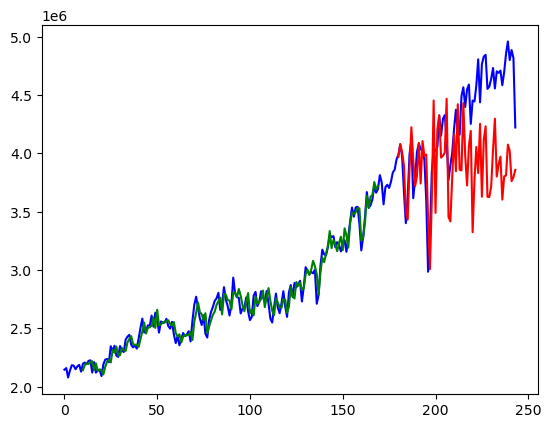

In [137]:
plot_pred(train_plot=train_plot, test_plot=test_plot)

Попробуем обучить еще

In [138]:
learning_loop(rnn_model=rnn_model)

epoch 0, train MSE 0.000585, test MSE 0.037063
epoch 100, train MSE 0.000609, test MSE 0.045181
epoch 200, train MSE 0.000570, test MSE 0.044683
epoch 300, train MSE 0.000561, test MSE 0.036308
epoch 400, train MSE 0.000524, test MSE 0.042991
epoch 500, train MSE 0.000504, test MSE 0.037361
epoch 600, train MSE 0.000558, test MSE 0.043170
epoch 700, train MSE 0.000474, test MSE 0.036019
epoch 800, train MSE 0.000458, test MSE 0.042970
epoch 900, train MSE 0.000443, test MSE 0.045155
epoch 1000, train MSE 0.000435, test MSE 0.045841


In [139]:
train_plot, test_plot = score_test(rnn_model=rnn_model, scaler=scaler)

Количество эпох: 3003
MAPE на обучающей выборке: 0.62%
MAPE на тестовой выборке: 12.45%


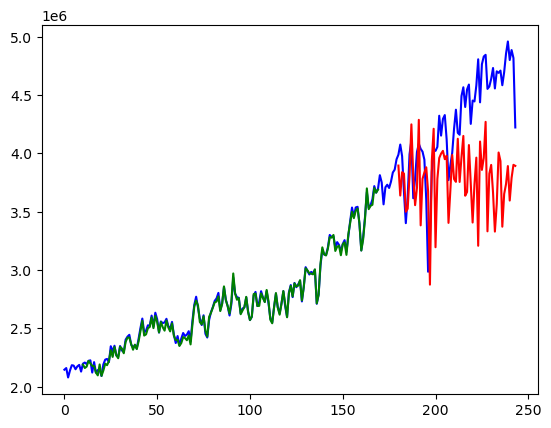

In [140]:
plot_pred(train_plot=train_plot, test_plot=test_plot)

Как можем заметить результаты только ухудшаются, хотя на обучающей выборке мы получаем очень хорошие результаты.

Это говорит о переобучении нашей модели.

Попробуем загрузить лучшую модель

In [141]:
model = RNN(
    input_size=1,
    hidden_size=50,
    num_layers=1,
)
model

RNN(
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (rnn): LSTM(1, 50, batch_first=True)
)

In [142]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [143]:
train_plot, test_plot = score_test(rnn_model=model, scaler=scaler)

Количество эпох: 0
MAPE на обучающей выборке: 2.54%
MAPE на тестовой выборке: 4.00%


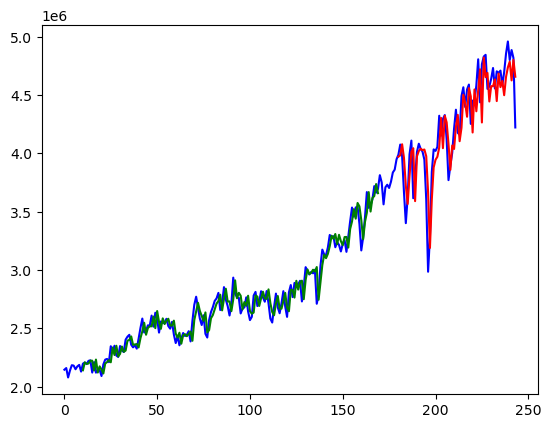

In [144]:
plot_pred(train_plot=train_plot, test_plot=test_plot)

## Выводы

LSTM модель достаточно хорошо предсказывает временной ряд. Это происходит по нескольким причинам:
* Архитектура устроена таким образом, что она способна хранить долгосрочные зависимости
* Хранит данные о предыдущих состояниях
* Может строить предсказания на данных с сезонностью и шумом

В нашем случае мы получили достаточно неплохие значения для предсказания тестовой выборки, но нужно быть аккуратнее, потому что модель легко переобучается.

Чтобы избавиться от переобучения, можно попробовать добавлить например дропаут или регуляризацию.

Также я думаю что имеет смысл использовать поиграть с гиперпараметрами, например добавить шедулер для learning rate. Поскольку изначально я обучался без нормализации, из-за чего обучение было очень долгим, изменение lr давало порой существенно более быстрое обучение.